# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

# MobileNetV2 model architecture

In [2]:
import torch.nn as nn
import math


def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=3, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building adaptive average pool
        self.adp_avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        # building dropout
        self.dropout = nn.Dropout(p=0.2, inplace=False)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.adp_avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


In [3]:
model = MobileNetV2()
model

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [4]:
import torch
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model.to(device), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Load CIFAR-10 dataset

In [5]:
# Define the transformations to apply to the CIFAR-10 data
transform = transforms.Compose([transforms.Resize((224,224)), #<-- Resize for EfficientNet input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load train and test data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:14<00:00, 11459112.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
# The classes in the dataset
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([3, 224, 224]) 0
Label:  airplane (0)


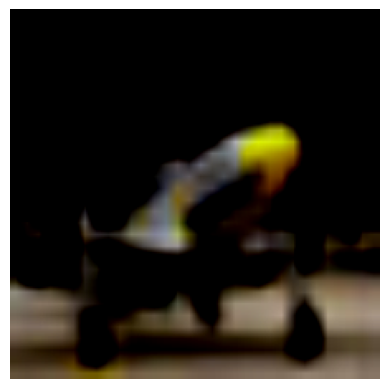

In [9]:
# Let's visualize the 12345th image in the train_dataset
feature, label = train_dataset[12344]
print(feature.shape, label)

# Permute the image tensor from 3x224x224 to 224x224x3
image = torch.permute(feature, (1, 2, 0))

# Display the image
plt.imshow(image)
print('Label: ', train_dataset.classes[label], "("+str(label)+")")
plt.axis('off') # To remove axis label
plt.show()

# Filtered Dataset

In [10]:
# Filter images from specific labels
desired_labels = [0, 1, 2]  # Airplane, Automobile, Bird
filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in desired_labels]
filtered_dataset = torch.utils.data.Subset(train_dataset, filtered_indices)

# Save the filtered dataset locally
save_path = "./filtered_dataset.pth"
torch.save(filtered_dataset, save_path)

print("Filtered dataset saved at:", save_path)

Filtered dataset saved at: ./filtered_dataset.pth


In [11]:
# Random split filtered dataset
from torch.utils.data import random_split

# Define the proportions for train and test split
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the sizes for train and test datasets
train_size = int(train_ratio * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size

# Split the dataset into train and test subsets
train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

# Verify the sizes of the train and test datasets
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 12000
Test dataset size: 3000


# DataLoadr for filtered dataset

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [13]:
# Example from train_loader
train_iterate = iter(train_loader)
features, labels = next(train_iterate)
features.shape

torch.Size([8, 3, 224, 224])

In [14]:
labels

tensor([2, 1, 0, 2, 2, 2, 2, 2])

# Training in filtered dataset

In [15]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define the loss function
criterion = nn.CrossEntropyLoss()

In [16]:
from tqdm import tqdm
import time

num_epochs = 10 # For less computation

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Update running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1) # the maximum value and the index of that maximum value along dimension 1
        running_corrects += torch.sum(preds == labels.data) # labels.data gives access to underlying labels tensor

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Calculate epoch loss and accuracy for training data
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


Epochs:  10%|█         | 1/10 [01:29<13:21, 89.10s/it]

Epoch 1 completed in 89.09 seconds
Epoch [1/10], Train Loss: 0.6943, Train Accuracy: 0.6977


Epochs:  20%|██        | 2/10 [02:52<11:27, 85.99s/it]

Epoch 2 completed in 83.81 seconds
Epoch [2/10], Train Loss: 0.5551, Train Accuracy: 0.7716


Epochs:  30%|███       | 3/10 [04:14<09:47, 83.89s/it]

Epoch 3 completed in 81.38 seconds
Epoch [3/10], Train Loss: 0.4780, Train Accuracy: 0.8067


Epochs:  40%|████      | 4/10 [05:36<08:18, 83.13s/it]

Epoch 4 completed in 81.95 seconds
Epoch [4/10], Train Loss: 0.4385, Train Accuracy: 0.8261


Epochs:  50%|█████     | 5/10 [06:58<06:54, 82.84s/it]

Epoch 5 completed in 82.32 seconds
Epoch [5/10], Train Loss: 0.3882, Train Accuracy: 0.8505


Epochs:  60%|██████    | 6/10 [08:20<05:30, 82.60s/it]

Epoch 6 completed in 82.10 seconds
Epoch [6/10], Train Loss: 0.3503, Train Accuracy: 0.8686


Epochs:  70%|███████   | 7/10 [09:43<04:07, 82.56s/it]

Epoch 7 completed in 82.47 seconds
Epoch [7/10], Train Loss: 0.3284, Train Accuracy: 0.8714


Epochs:  80%|████████  | 8/10 [11:05<02:44, 82.36s/it]

Epoch 8 completed in 81.91 seconds
Epoch [8/10], Train Loss: 0.2907, Train Accuracy: 0.8913


Epochs:  90%|█████████ | 9/10 [12:26<01:22, 82.07s/it]

Epoch 9 completed in 81.43 seconds
Epoch [9/10], Train Loss: 0.2610, Train Accuracy: 0.9007


Epochs: 100%|██████████| 10/10 [13:47<00:00, 82.77s/it]

Epoch 10 completed in 81.11 seconds
Epoch [10/10], Train Loss: 0.2294, Train Accuracy: 0.9142


# Testing the model

In [17]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    model.eval() # Set the model to evaluation mode

    for inputs, labels in test_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 91.50%


# Save the model

In [18]:
save_path = "MobileNetV2_scratch.pth"
torch.save(model.state_dict(), save_path)

print("Trained model saved at:", save_path)

Trained model saved at: MobileNetV2_scratch.pth


# Inference

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model
    model = MobileNetV2()
    model.load_state_dict(torch.load("/content/MobileNetV2_scratch.pth", map_location=torch.device('cpu')))
    model.eval()
    model = model.to(device)

    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    input_image = transform(image).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image)

    _, predicted = torch.max(output.data, 1)

    # Get the predicted class probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]

    # Get the predicted class label
    predicted_class = torch.argmax(probabilities).item()

    return probabilities, predicted_class

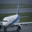

Predicted class: bird
Probability: 0.6751207709312439


In [23]:
# Test on airplane
image_path = "/content/airplane.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

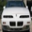

Predicted class: automobile
Probability: 0.6648421883583069


In [21]:
# Test on automobile
image_path = "/content/automobile.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())

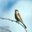

Predicted class: bird
Probability: 0.830009400844574


In [22]:
# Test on bird
image_path = "/content/bird.png"
image = Image.open(image_path)
image.show()

probabilities, predicted_class = predict(image)

class_labels = ['airplane', 'automobile', 'bird']

# Print the predicted class label and corresponding probability
print("Predicted class:", class_labels[predicted_class])
print("Probability:", probabilities[predicted_class].item())